# **DATASET 1**

In [601]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [602]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [603]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9616
Epoch: 002, Loss: 1.9547
Epoch: 003, Loss: 1.9474
Epoch: 004, Loss: 1.9377
Epoch: 005, Loss: 1.9283
Epoch: 006, Loss: 1.9211
Epoch: 007, Loss: 1.9070
Epoch: 008, Loss: 1.8965
Epoch: 009, Loss: 1.8814
Epoch: 010, Loss: 1.8705
Epoch: 011, Loss: 1.8603
Epoch: 012, Loss: 1.8346
Epoch: 013, Loss: 1.8223
Epoch: 014, Loss: 1.8063
Epoch: 015, Loss: 1.7885
Epoch: 016, Loss: 1.7667
Epoch: 017, Loss: 1.7453
Epoch: 018, Loss: 1.7336
Epoch: 019, Loss: 1.7059
Epoch: 020, Loss: 1.6866
Epoch: 021, Loss: 1.6669
Epoch: 022, Loss: 1.6577
Epoch: 023, Loss: 1.6027
Epoch: 024, Loss: 1.5802
Epoch: 025, Loss: 1.5592
Epoch: 026, Loss: 1.5176
Epoch: 027, Loss: 1.4965
Epoch: 028, Loss: 1.4731
Epoch: 029, Loss: 1.4520
Epoch: 030, Loss: 1.4109
Epoch: 031, Loss: 1.3903
Epoch: 032, Loss: 1.3524
Epoch: 033, Loss: 1.3294
Epoch: 034, Loss: 1.2846
Epoch: 035, Loss: 1.2700
Epoch: 036, Loss: 1.2279
Epoch: 037, Loss: 1.2142
Epoch: 038, Loss: 1.1839
Epoch: 039, Loss: 1.1380
Epoch: 040, Loss: 1.1123


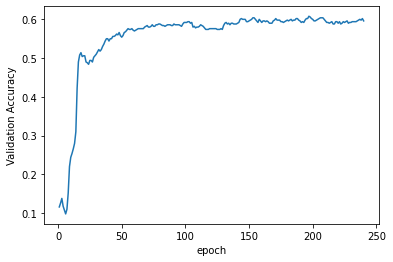

In [604]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
import numpy as np

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

epoch_validate = 30
num_avg = 30

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def validate():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      return val_acc

validations = []
max_val_acc = 0

stop = False
epoch = 1
while(not stop):
  loss = train()
  validations.append(validate())
  if validations[epoch-1] > max_val_acc:
    max_val_acc = validations[epoch-1]
    torch.save(model.state_dict(), "best_model.pt")
  if epoch % epoch_validate == 0 and epoch > num_avg:
    if np.mean(validations[epoch-num_avg : epoch]) < np.mean(validations[epoch-num_avg-num_avg : epoch-num_avg]):
      model.load_state_dict(torch.load("best_model.pt"))
      stop = True
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
  if stop == True:
    plt.plot(np.linspace(1, epoch, epoch), validations)
    plt.xlabel('epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()
  epoch += 1

After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [605]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

val_acc = validate()
print(f'Val Accuracy: {val_acc:.4f}')

Test Accuracy: 0.6050
Val Accuracy: 0.6080


As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single linear layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [606]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

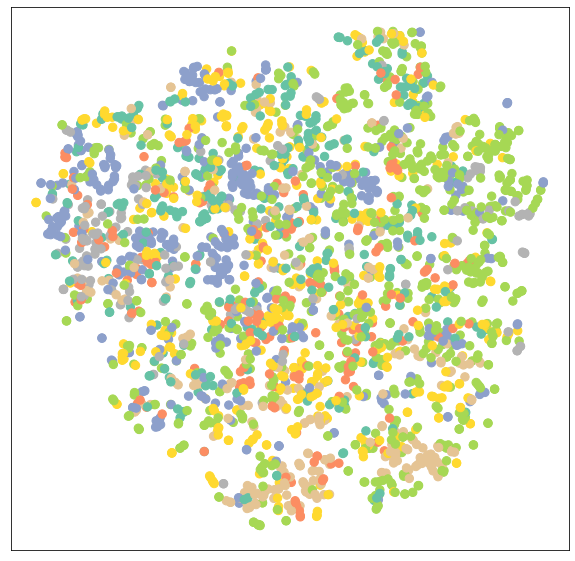

In [607]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

As one can see, there is at least *some kind* of clustering (*e.g.*, for the "blue" nodes), but we certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9451
Epoch: 002, Loss: 1.9380
Epoch: 003, Loss: 1.9290
Epoch: 004, Loss: 1.9202
Epoch: 005, Loss: 1.9086
Epoch: 006, Loss: 1.8998
Epoch: 007, Loss: 1.8842
Epoch: 008, Loss: 1.8747
Epoch: 009, Loss: 1.8631
Epoch: 010, Loss: 1.8489
Epoch: 011, Loss: 1.8301
Epoch: 012, Loss: 1.8199
Epoch: 013, Loss: 1.8050
Epoch: 014, Loss: 1.7820
Epoch: 015, Loss: 1.7729
Epoch: 016, Loss: 1.7543
Epoch: 017, Loss: 1.7416
Epoch: 018, Loss: 1.7295
Epoch: 019, Loss: 1.7045
Epoch: 020, Loss: 1.6854
Epoch: 021, Loss: 1.6681
Epoch: 022, Loss: 1.6408
Epoch: 023, Loss: 1.6235
Epoch: 024, Loss: 1.6063
Epoch: 025, Loss: 1.5819
Epoch: 026, Loss: 1.5589
Epoch: 027, Loss: 1.5460
Epoch: 028, Loss: 1.5275
Epoch: 029, Loss: 1.5008
Epoch: 030, Loss: 1.4842
Epoch: 031, Loss: 1.4474
Epoch: 032, Loss: 1.4176
Epoch: 033, Loss: 1.4184
Epoch: 034, Loss: 1.3677
Epoch: 035, Loss: 1.3758
Epoch: 036, Loss: 1.3180
Epoch: 037, Loss: 1.3358
Epoch: 038, Loss: 1.2902
Epoch: 039, Loss: 1.2816
Epoch: 040, Loss: 1.2345


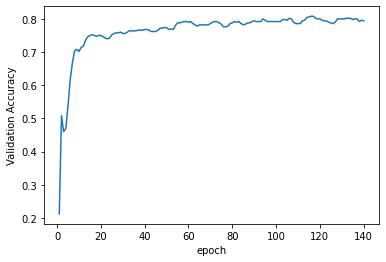

In [608]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

epoch_validate = 20
num_avg = epoch_validate

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def validate():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      return val_acc

validations = []
max_val_acc = 0

stop = False
epoch = 1
while(not stop):
  loss = train()
  validations.append(validate())
  if validations[epoch-1] > max_val_acc:
    max_val_acc = validations[epoch-1]
    torch.save(model.state_dict(), "best_model.pt")
  if epoch % epoch_validate == 0 and epoch > num_avg:
    if np.mean(validations[epoch-num_avg : epoch]) < np.mean(validations[epoch-num_avg-num_avg : epoch-num_avg]):
      model.load_state_dict(torch.load("best_model.pt"))
      stop = True
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
  if stop == True:
    plt.plot(np.linspace(1, epoch, epoch), validations)
    plt.xlabel('epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()
  epoch += 1



After training the model, we can check its test accuracy:

In [609]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

val_acc = validate()
print(f'Val Accuracy: {val_acc:.4f}')

Test Accuracy: 0.8220
Val Accuracy: 0.8080


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.4% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

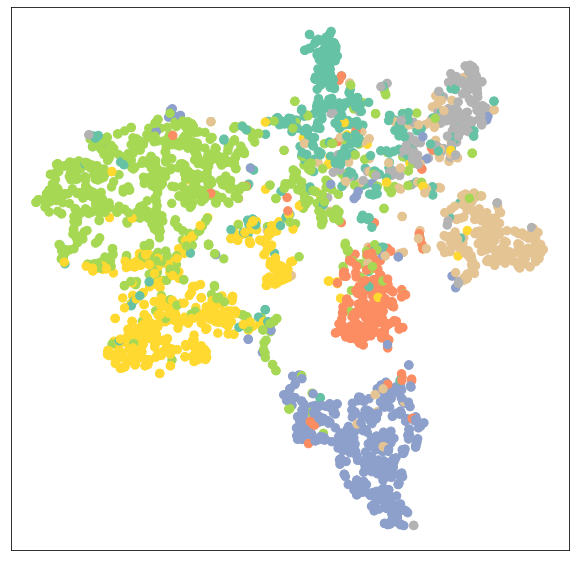

In [610]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

In [611]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, n_heads):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=n_heads)
        self.conv2 = GATConv(hidden_channels * n_heads, hidden_channels, heads=n_heads, dropout=0.25)
        self.conv3 = GATConv(hidden_channels * n_heads, dataset.num_classes, heads=n_heads, dropout=0.25)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT(hidden_channels=32, n_heads=4)
print(model)

GAT(
  (conv1): GATConv(1433, 32, heads=4)
  (conv2): GATConv(128, 32, heads=4)
  (conv3): GATConv(128, 7, heads=4)
)


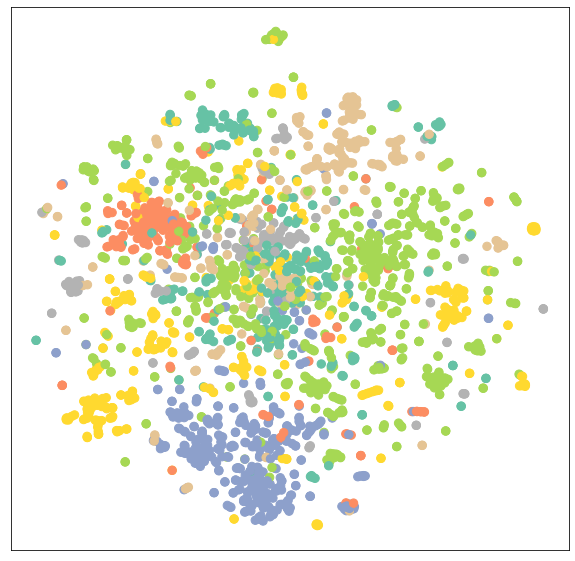

In [612]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 3.3329
Epoch: 002, Loss: 3.2691
Epoch: 003, Loss: 3.1473
Epoch: 004, Loss: 2.9484
Epoch: 005, Loss: 2.6712
Epoch: 006, Loss: 2.3782
Epoch: 007, Loss: 2.1333
Epoch: 008, Loss: 2.0207
Epoch: 009, Loss: 1.9532
Epoch: 010, Loss: 1.9091
Epoch: 011, Loss: 1.9134
Epoch: 012, Loss: 1.8883
Epoch: 013, Loss: 1.8746
Epoch: 014, Loss: 1.8512
Epoch: 015, Loss: 1.8378
Epoch: 016, Loss: 1.7890
Epoch: 017, Loss: 1.7598
Epoch: 018, Loss: 1.7631
Epoch: 019, Loss: 1.7132
Epoch: 020, Loss: 1.6111
Epoch: 021, Loss: 1.5723
Epoch: 022, Loss: 1.5492
Epoch: 023, Loss: 1.4665
Epoch: 024, Loss: 1.3863
Epoch: 025, Loss: 1.2925
Epoch: 026, Loss: 1.2718
Epoch: 027, Loss: 1.1706
Epoch: 028, Loss: 1.0578
Epoch: 029, Loss: 0.9632
Epoch: 030, Loss: 0.9105
Epoch: 031, Loss: 0.9203
Epoch: 032, Loss: 0.7989
Epoch: 033, Loss: 0.7804
Epoch: 034, Loss: 0.6408
Epoch: 035, Loss: 0.5766
Epoch: 036, Loss: 0.6101
Epoch: 037, Loss: 0.4394
Epoch: 038, Loss: 0.4807
Epoch: 039, Loss: 0.4825
Epoch: 040, Loss: 0.3692


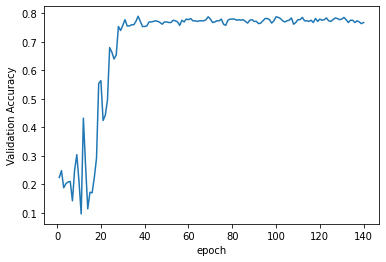

In [613]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=32, n_heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

epoch_validate = 20
num_avg = epoch_validate

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def validate():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      return val_acc

validations = []
max_val_acc = 0

stop = False
epoch = 1
while(not stop):
  loss = train()
  validations.append(validate())
  if validations[epoch-1] > max_val_acc:
    max_val_acc = validations[epoch-1]
    torch.save(model.state_dict(), "best_model.pt")
  if epoch % epoch_validate == 0 and epoch > num_avg:
    if np.mean(validations[epoch-num_avg : epoch]) < np.mean(validations[epoch-num_avg-num_avg : epoch-num_avg]):
      model.load_state_dict(torch.load("best_model.pt"))
      stop = True
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
  if stop == True:
    plt.plot(np.linspace(1, epoch, epoch), validations)
    plt.xlabel('epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()
  epoch += 1

In [614]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

val_acc = validate()
print(f'Val Accuracy: {val_acc:.4f}')

Test Accuracy: 0.8140
Val Accuracy: 0.7900


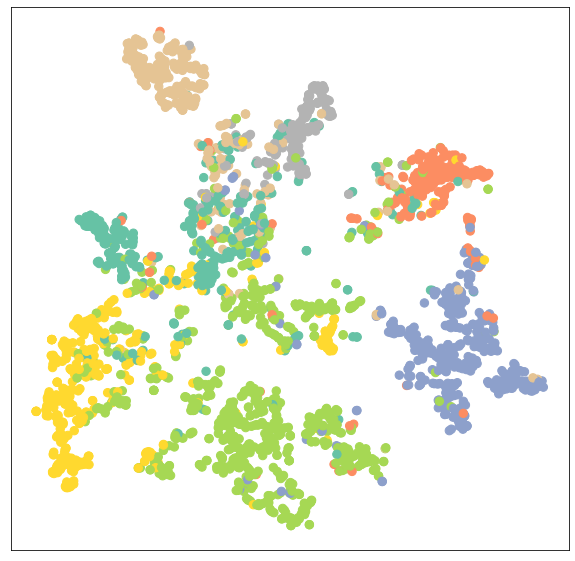

In [615]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# **DATASET 2**

In [616]:
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.data import DataLoader

In [618]:
from google.colab import files
upload = files.upload()
dataset = torch.load('graphs.pt')

Saving graphs.pt to graphs.pt


In [621]:
train_data = dataset[0 : int(0.8 * len(dataset))]   # 80 percent as training data
test_data = dataset[int(0.8 * len(dataset)) : int(len(dataset))] # 20 percent as testing data

train_chunks = DataLoader(train_data, batch_size=64, shuffle=True)
test_chunks = DataLoader(test_data, batch_size=64, shuffle=False)

In [622]:
class GNN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, dense_size, dropout):
    super(GNN, self).__init__()
    torch.manual_seed(12345)
    self.conv1 = GraphConv(in_channels, hidden_channels).double()
    self.conv2 = GraphConv(hidden_channels, hidden_channels).double()
    self.conv3 = GraphConv(hidden_channels, hidden_channels).double()
    self.dense1 = Linear(hidden_channels, dense_size).double()
    self.dense2 = Linear(dense_size, dense_size).double()
    self.dense3 = Linear(dense_size, out_channels).double()
    self.log_softmax = torch.nn.LogSoftmax()
    self.dropout = dropout

  def forward(self, x, edge_index, edge_attr, batch):
    edge_index = edge_index.long()
    edge_attr = edge_attr.long()
    batch = batch.long()
    x = self.conv1(x, edge_index, edge_attr)
    x = x.relu()
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.conv2(x, edge_index, edge_attr)
    x = x.relu()
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.conv3(x, edge_index, edge_attr)
    x = global_mean_pool(x, batch)
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.dense1(x)
    x = x.relu()
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.dense2(x)
    x = x.relu()
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.dense3(x)
    x = self.log_softmax(x)
    return x

model = GNN(in_channels=2, hidden_channels=8, out_channels=4, dense_size=8, dropout=0.25)
print(model)


GNN(
  (conv1): GraphConv(2, 8)
  (conv2): GraphConv(8, 8)
  (conv3): GraphConv(8, 8)
  (dense1): Linear(in_features=8, out_features=8, bias=True)
  (dense2): Linear(in_features=8, out_features=8, bias=True)
  (dense3): Linear(in_features=8, out_features=4, bias=True)
  (log_softmax): LogSoftmax(dim=None)
)


In [623]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GNN(in_channels=2, hidden_channels=64, out_channels=4, dense_size=64, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.KLDivLoss()

def train():
      model.train()
      for chunk in train_chunks: # Iter. over chunks of training data
        out = model(chunk.x, chunk.edge_index, chunk.edge_attr, chunk.batch)
        loss = criterion(out, chunk.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
      return loss

def test(chunks):
      model.eval()
      sum = 0
      for chunk in chunks: # Iter. over chunks of training data
        out = model(chunk.x, chunk.edge_index, chunk.edge_attr, chunk.batch)
        pred = out.argmax(dim=1)
        sum += int((pred == chunk.y.argmax(dim=1)).sum())
      return sum / len(chunks.dataset)

max_acc = 0
for epoch in range(1, 201):
  loss = train()
  train_acc, current_test_acc = test(train_chunks), test(test_chunks)
  if max_acc < current_test_acc:
    max_acc = current_test_acc
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {max_acc:.4f}, Train Acc: {train_acc:.4f}')

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 001, Loss: 0.2603, Test Acc: 0.0800, Train Acc: 0.6778
Epoch: 002, Loss: 0.2287, Test Acc: 0.2238, Train Acc: 0.7391
Epoch: 003, Loss: 0.1844, Test Acc: 0.6600, Train Acc: 0.7734
Epoch: 004, Loss: 0.1652, Test Acc: 0.6600, Train Acc: 0.7806
Epoch: 005, Loss: 0.2178, Test Acc: 0.6600, Train Acc: 0.7856
Epoch: 006, Loss: 0.2551, Test Acc: 0.6600, Train Acc: 0.7769
Epoch: 007, Loss: 0.1662, Test Acc: 0.6763, Train Acc: 0.7919
Epoch: 008, Loss: 0.1822, Test Acc: 0.6763, Train Acc: 0.7972
Epoch: 009, Loss: 0.1899, Test Acc: 0.6800, Train Acc: 0.7959
Epoch: 010, Loss: 0.1624, Test Acc: 0.6800, Train Acc: 0.7844
Epoch: 011, Loss: 0.1835, Test Acc: 0.6800, Train Acc: 0.8047
Epoch: 012, Loss: 0.1898, Test Acc: 0.7025, Train Acc: 0.7950
Epoch: 013, Loss: 0.2266, Test Acc: 0.7025, Train Acc: 0.7875
Epoch: 014, Loss: 0.1705, Test Acc: 0.7025, Train Acc: 0.8031
Epoch: 015, Loss: 0.1245, Test Acc: 0.7025, Train Acc: 0.7981
Epoch: 016, Loss: 0.2039, Test Acc: 0.7025, Train Acc: 0.7963
Epoch: 0

In [624]:
print(f'Test Accuracy: {max_acc:.4f}')
print(f'Train Accuracy: {train_acc:.4f}')

Test Accuracy: 0.7550
Train Accuracy: 0.8059
